In [63]:
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torchvision.models.resnet import ResNet, BasicBlock
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,Dataset
import torchvision.utils
import numpy as np
import random
from PIL import Image
import PIL.ImageOps
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm.autonotebook import tqdm as tqdm_jupyter
from tqdm import tqdm as tqdm_bash
import inspect
import os
import time
from siamese_tools import *
import matplotlib.pyplot as plt
import matplotlib
import itertools
from queue import Queue
import pandas as pd
import random
import json
from sklearn.manifold import TSNE
from umap import UMAP

In [3]:
def dist(tens1,tens2,scalar=1):
    tens1 = (tens1.type(torch.cuda.DoubleTensor)*scalar).cpu().numpy().astype(np.longdouble)
    tens2 = (tens2.type(torch.cuda.DoubleTensor)*scalar).cpu().numpy().astype(np.longdouble)
    sub = tens1-tens2
    sqr = np.power(sub,2)
    s = np.sum(sqr,axis=1)
    dis = np.power(s,0.5)
    return dis
def print_stats(x,y):
    conf_m = confusion_matrix(x,y)
    print("       precision: {0:.4f}".format(precision_score(x,y)))
    print("        accuracy: {0:.4f}".format(accuracy_score(x,y)))
    print("        f1 score: {0:.4f}".format(f1_score(x,y)))
    print("           recal: {0:.4f}".format(recall_score(x,y)))
    print("confusion matrix: [{}\n                  {}]".format(conf_m[0],conf_m[1]))
def multiclass_stats(x,y):
    print("confusion matrix: "+confusion_matrix(x,y))
def euclidean_distance(a,b):
    # Fast euclidean distance
    # Modified from: https://stackoverflow.com/a/47775357/6454085
    a_min_b = a - b
    return np.sqrt(np.einsum("ij,ij->j", a_min_b, a_min_b))
def triangular_number(n):
    # From https://codereview.stackexchange.com/a/92176
    return n * (n + 1) // 2

# Settings for Validation
## Base CNN

In [4]:
model_name = "skw.base_cnn.v1"
epochs = 20
batch_size = 64
pbar_type = "jupyter"
image_type = "L"
model_path = os.path.join("models",model_name+".ep_"+str(epochs),"epoch_19.pt")
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()])
model_class = SiameseNetwork

## Base ResNet

In [5]:
model_name = "skw.base_resnet.v1"
epochs = 20
batch_size = 64
pbar_type = "jupyter"
image_type = "RGB"
model_path = os.path.join("models",model_name+".ep_"+str(epochs),"best.pt")
transformation = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])
model_class = SiameseResNet

In [6]:
root_dir = "data"
test_dir = os.path.join(root_dir,"test")

im_test_dset = dset.ImageFolder(root=test_dir,transform=transformation)
index_to_class_name = dict([(value, key) for key, value in im_test_dset.class_to_idx.items()])

val_loader = DataLoader(im_test_dset,shuffle=True,num_workers=0,batch_size=batch_size)

loss_function = ContrastiveLoss()
print("CUDA availability:",torch.cuda.is_available())
print("Using model:", model_path)

CUDA availability: True
Using model: models\skw.base_resnet.v1.ep_20\best.pt


# Calculate Siamese Vectors for each image

In [29]:
model = model_class()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
val_batches = len(val_loader)

preds = []
first = True

model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()

loss_function = ContrastiveLoss()

if torch.cuda.is_available():
    torch.cuda.empty_cache()
with torch.no_grad():
    progress = None
    if pbar_type == "bash":
        progress = tqdm_bash(enumerate(val_loader,0), total=val_batches, unit=" batch(es)", position=0, leave=True)
    if pbar_type == "jupyter":
        progress = tqdm_jupyter(enumerate(val_loader,0), total=val_batches, unit=" batch(es)")
    prev_data = []
    for i,data in progress:
        if i%2 == 0:
            prev_data = data
            
        else:
            img0,img0_class = data
            img1,img1_class = prev_data
            img0, img1 = img0.to(device), img1.to(device)

            output0, output1 = model(img0,img1)
            for j in range(len(output1)):
                if first:
                    first = False
                    preds = np.array([[output0[j].cpu().numpy(),img0_class[j].cpu().numpy()]])
                    preds = np.append(preds, [[output1[j].cpu().numpy(),img1_class[j].cpu().numpy()]],axis=0)
                else:
                    preds = np.append(preds, [[output0[j].cpu().numpy(),img0_class[j].cpu().numpy()]],axis=0)
                    preds = np.append(preds, [[output1[j].cpu().numpy(),img1_class[j].cpu().numpy()]],axis=0)
            prev_data = -1

        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    if prev_data != -1:
        img1,img1_class = prev_data
        img1 = img1.to(device)

        output0, output1 = model(img1,img1)
        for j in range(len(output1)):
            if first:
                preds = np.array([[output0[j].cpu().numpy(),img0_class[j].cpu().numpy()]])
            else:
                preds = np.append(preds, [[output0[j].cpu().numpy(),img0_class[j].cpu().numpy()]],axis=0)
        prev_data = -1

C:\Users\LionHeart\Anaconda2\envs\Project Sidewalk\lib\site-packages\ipykernel_launcher.py:53: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [57]:
processed_preds = []
first = True
for i in preds:
    if first:
        processed_preds = [np.append(i[1],i[0])]
        first = False
    else:
        processed_preds = np.append(processed_preds, [np.append(i[1],i[0])],axis=0)
np.savetxt(model_name+".validations.csv", processed_preds, delimiter=',')

## Reduce the number of items in each class to the min of all the classes

In [7]:
df = pd.read_csv(model_name+".validations.csv",header=None,dtype=np.float64)
df.insert(0,"index",df.index)
filtered_vectors = []
unique_classes = df[0].unique()
print("Using classes {}".format(unique_classes))
min_len = -1
for c in unique_classes:
    c_len = len(df[df[0] == c])
    if min_len < 0 or min_len > c_len:
        min_len = c_len
for c in unique_classes:
    filtered_class = df[df[0]==c].values.tolist()
    np.random.shuffle(filtered_class)
    filtered_vectors += filtered_class[:min_len]
filtered_vectors = np.array(filtered_vectors)
num_combs = len(list(itertools.combinations(filtered_vectors, 2)))
print('{} total comparisons'.format(num_combs))

Using classes [0. 3. 4. 1. 2.]
19310005 total comparisons


## Make distance comparisons between each combination of vectors

In [45]:
if pbar_type == "bash":
    progress = tqdm_bash(enumerate(itertools.combinations(filtered_vectors, 2)), total=num_combs, unit=" comparison(s)", position=0, leave=True)
if pbar_type == "jupyter":
    progress = tqdm_jupyter(enumerate(itertools.combinations(filtered_vectors, 2)), total=num_combs, unit=" comparison(s)")

distances = []
last3 = []
distance_per_vector = dict([(int(value), [0,0]) for value in filtered_vectors[:,0]])
for i,comb in progress:
    last3.append(comb)
    if i % 3 == 2:
        a = np.zeros((3,len(comb[0][2:])))
        b = np.zeros((3,len(comb[0][2:])))
        for j in range(3):
            a[j] = last3[j][0][2:]
            b[j] = last3[j][1][2:]
        dsts = euclidean_distance(a.T,b.T)
        for j in range(3):
            comparison = np.concatenate([[dsts[j]],[last3[j][0][1]],[last3[j][1][1]]])
            distances.append(comparison)
            if last3[j][0][1] == last3[j][1][1]:
                distance_per_vector[last3[j][0][0]][0] += dsts[j]
                distance_per_vector[last3[j][1][0]][0] += dsts[j]
            else:
                distance_per_vector[last3[j][0][0]][1] += dsts[j]
                distance_per_vector[last3[j][1][0]][1] += dsts[j]
        last3 = []

In [50]:
df_dist = pd.DataFrame(distances,columns=['distance','class1','class2'])
df_dist.to_csv(model_name+'.comparisons.csv', index=False)

with open(model_name+'.distance_per_vector.json', 'w') as f:
    json.dump(distance_per_vector, f)

# Evaluate Siamese Nets for Binary Classification

<IPython.core.display.Javascript object>


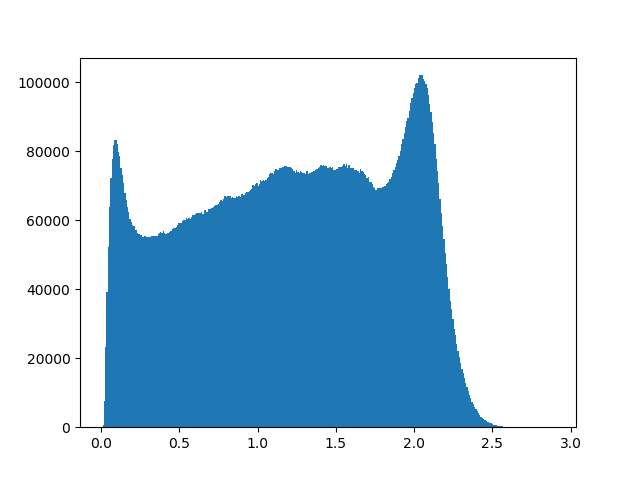

In [34]:
distance_per_vector = {}
with open(model_name+'.distance_per_vector.json') as f:
    distance_per_vector = json.load(f)

df_dist = pd.read_csv(model_name+".comparisons.csv")
plt.hist(df_dist['distance'], bins='auto')
plt.show()

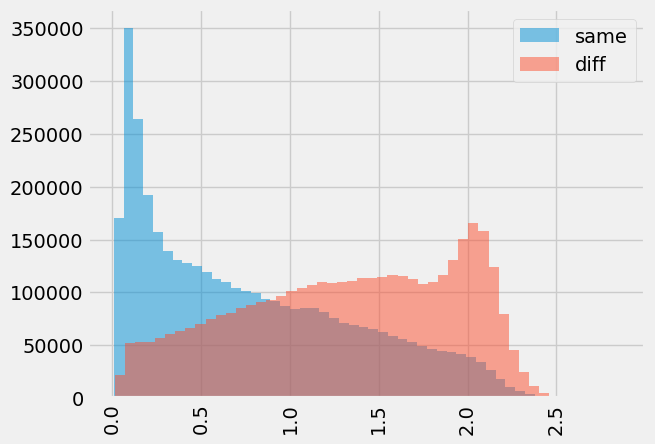

In [174]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.style.use('fivethirtyeight')#'ggplot')

same = df_dist[df_dist['class1'] == df_dist['class2']]['distance']
diff_large = df_dist[df_dist['class1'] != df_dist['class2']]['distance']

diff = diff_large.values.tolist()
d_part = len(diff)/len(same)
np.random.shuffle(diff)
diff = pd.Series(diff[:int(len(diff)/d_part)])

bins = 50
plt.hist(same, bins, alpha=0.5, label='same')
plt.hist(diff, bins, alpha=0.5, label='diff')
plt.legend(loc='upper right')
plt.xticks(rotation='vertical')
plt.savefig(model_name+".ep_"+str(epochs)+".full_test"+".png", bbox_inches='tight')
plt.show()

In [37]:
step_size = 0.0001
mid = np.mean(df_dist['distance'])
rng = max(df_dist['distance'])/6
cutoffs = np.arange(mid-rng,mid+rng,step_size)
print("Checking "+str(len(cutoffs))+" clipping values from {0:.2f} to {1:.2f} in increments of ".format(mid-rng,mid+rng)+str(step_size))
sames = np.array([])
diffs = np.array([])

if pbar_type == "bash":
    progress = tqdm_bash(cutoffs, total=len(cutoffs), unit=" comparison(s)", position=0, leave=True)
if pbar_type == "jupyter":
    progress = tqdm_jupyter(cutoffs, total=len(cutoffs), unit=" comparison(s)")

for cutoff in progress:
    sames = np.append(sames,sum(same[same<cutoff]))
    diffs = np.append(diffs,np.sum(diff[diff>cutoff]))

Checking 9684 clipping values from 0.73 to 1.70 in increments of 0.0001


In [64]:
cutoff = cutoffs[np.argmax(sames+diffs)]
preds = df_dist['distance'].values.tolist()
lbls = np.where(df_dist['class1'] == df_dist['class2'],0,1)
thresh_preds = np.zeros(len(preds))
for i in range(len(preds)):
    if preds[i] > cutoff:
        thresh_preds[i] = 1
print("Using a cutoff of {0:.4f}".format(cutoff))
print_stats(thresh_preds,lbls)

Using a cutoff of 0.8634
       precision: 0.7409
        accuracy: 0.7136
        f1 score: 0.8054
           recal: 0.8822
confusion matrix: [[2331533 4003141]
                  [ 1527981 11447349]]


# Evaluate Siamese Nets for Multi-Cla Classification

In [117]:
class_vectors = {}
class_name_to_index = {}

for i,c in enumerate(np.sort(unique_classes)):
    # Use the average Vector for each class
    #class_vec = np.average([vec[1:] for vec in df[df[0]==c].values.tolist()], axis=0)
    # Use the average Vector for each class
    to_check = [str(int(col[0])) for col in df[df[0]==c].values.tolist()]
    best_vec_id = -1
    best_vec_score = 0
    for idx in to_check:
        if idx in distance_per_vector:
            score = distance_per_vector[idx][1] - 5*distance_per_vector[idx][0]
            if score > best_vec_score:
                best_vec_id = idx
                best_vec_score = score
    class_vec = df[df['index'] == float(best_vec_id)].values.tolist()[0][2:]
    class_vectors[c] = class_vec
    class_name_to_index[index_to_class_name[c]] = i

In [118]:
distances = np.zeros((len(df.values.tolist()),len(class_vectors)))
lbls = np.array([])
b = np.array(list(class_vectors.values()))

for i,comb in enumerate(df.values.tolist()):
    lbls = np.append(lbls,comb[1])
    a = np.tile([comb[2:]],(len(class_vectors),1))
    dsts = euclidean_distance(a.T,b.T)
    distances[i] = dsts
lbls = lbls.astype(int)

In [119]:
multi_class_preds = np.argmin(distances,axis=1)
print(classification_report(multi_class_preds, lbls, target_names=list(index_to_class_name.values())))

              precision    recall  f1-score   support

           1       0.89      0.89      0.89     18701
           2       0.36      0.38      0.37      2418
           3       0.61      0.67      0.64      2941
           4       0.38      0.19      0.25      2471
           8       0.83      0.87      0.85     15999

    accuracy                           0.80     42530
   macro avg       0.61      0.60      0.60     42530
weighted avg       0.79      0.80      0.79     42530



# Train and Test SVM on Siamese Outputs

In [106]:
unfiltered_vectors = df.values.tolist()
X_train, X_test, y_train, y_test = train_test_split([vec[2:] for vec in unfiltered_vectors], [vec[1] for vec in unfiltered_vectors], test_size=0.2, shuffle=True)

print("Train Set distrubution:")
for c in np.unique(y_train):
    print(" {}: {}".format(list(index_to_class_name.values())[int(c)],y_train.count(c)))
print()
print("Test Set distrubution:")
for c in np.unique(y_test):
    print(" {}: {}".format(list(index_to_class_name.values())[int(c)],y_test.count(c)))

classifier = SVC(gamma=0.001,class_weight="balanced")

Train Set distrubution:
 1: 14991
 2: 2049
 3: 2602
 4: 975
 8: 13407

Test Set distrubution:
 1: 3773
 2: 517
 3: 655
 4: 268
 8: 3293


In [107]:
classifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [108]:
SVC_preds = classifier.predict(X_test)
print(classification_report(SVC_preds, y_test, target_names=list(index_to_class_name.values())))

              precision    recall  f1-score   support

           1       0.89      0.90      0.89      3732
           2       0.10      0.31      0.16       176
           3       0.68      0.63      0.65       709
           4       0.48      0.19      0.27       674
           8       0.84      0.86      0.85      3215

    accuracy                           0.79      8506
   macro avg       0.60      0.58      0.56      8506
weighted avg       0.80      0.79      0.79      8506



# Visualize Siamese Outputs with tSNE and UMAP

In [58]:
from mpl_toolkits.mplot3d import Axes3D

vectors = [vec[2:] for vec in filtered_vectors]
tsne = TSNE(n_components=3, verbose=1, perplexity=250, n_iter=5000)
tsne_results = tsne.fit_transform(vectors)

[t-SNE] Computing 751 nearest neighbors...
[t-SNE] Indexed 6215 samples in 0.031s...
[t-SNE] Computed neighbors for 6215 samples in 4.194s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6215
[t-SNE] Computed conditional probabilities for sample 2000 / 6215
[t-SNE] Computed conditional probabilities for sample 3000 / 6215
[t-SNE] Computed conditional probabilities for sample 4000 / 6215
[t-SNE] Computed conditional probabilities for sample 5000 / 6215
[t-SNE] Computed conditional probabilities for sample 6000 / 6215
[t-SNE] Computed conditional probabilities for sample 6215 / 6215
[t-SNE] Mean sigma: 0.058579
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.595684
[t-SNE] KL divergence after 2450 iterations: 0.365284


<IPython.core.display.Javascript object>


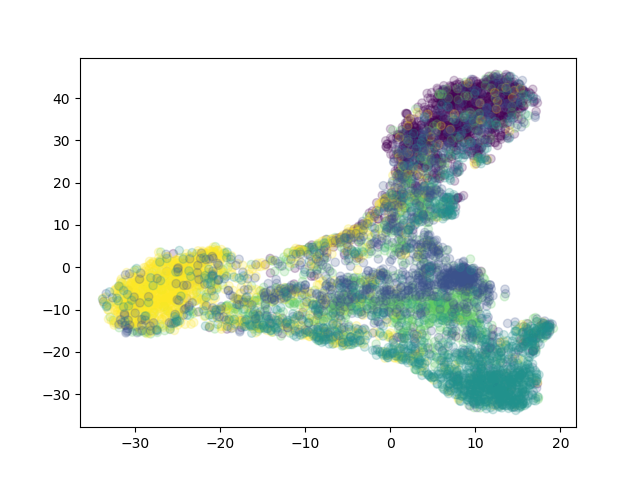

In [57]:
plt.figure()
plt.scatter(tsne_results[:,0], tsne_results[:,1],c=c,alpha=0.2)
plt.show()

<IPython.core.display.Javascript object>


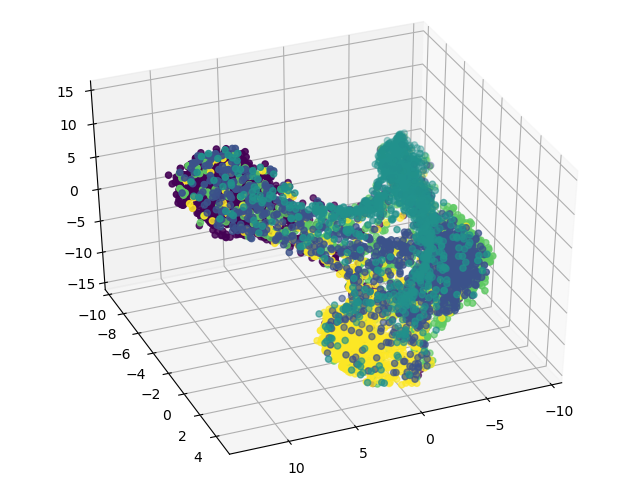

In [62]:
%matplotlib notebook
c = [vec[1] for vec in filtered_vectors]

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(tsne_results[:,0], tsne_results[:,1], tsne_results[:,2],c=c)
plt.show()

In [41]:
u = UMAP(n_components=2, metric='euclidean', min_dist=0.15, n_neighbors=500)
embedding = u.fit_transform(vectors)

C:\Users\LionHeart\Anaconda2\envs\Project Sidewalk\lib\site-packages\numba\compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "C:\Users\LionHeart\Anaconda2\envs\Project Sidewalk\lib\site-packages\umap\nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


<IPython.core.display.Javascript object>


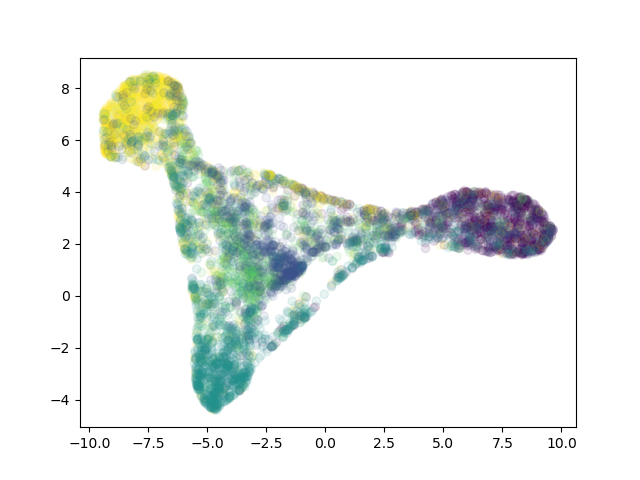

In [42]:
plt.figure()
plt.scatter(embedding[:, 0], embedding[:, 1], c=c, alpha=0.1)